In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

Load Data

In [3]:
priceData = pd.read_csv("Data/portfolioAdjPriceData.csv", index_col=0)

Calculate Returns

In [4]:
numAssets = len(priceData.columns)

returnData = pd.DataFrame()
# Calculate Returns for Every Asset
for asset in priceData.head():
    returnData[str(asset + "_returns")] = (priceData[asset] - priceData[asset].shift(1)) / priceData[asset].shift(1)

# Drop first row of Returns
returnData = returnData.drop(returnData.index[0])

Do preliminary calculations

In [5]:
# Calculate Historical Returns
historicalReturns = returnData.mean()

# Convert Returns to Array
historicalReturns = historicalReturns.to_numpy()

# Calculate Risk
risk = returnData.std().to_numpy()

covMatrix = returnData.cov().to_numpy()

# Define RF (monthly)
irx = 0.98
rf = irx*.01/12

# GMV

In [7]:
# GMV Calculation
# Create b
b = np.zeros( (numAssets+1, 1) )
# Set Initial Constraint (w'1 = 1)
b[numAssets, 0] = 1

# Create A
A = np.zeros( (numAssets+1, numAssets+1) )

A[0:numAssets, 0:numAssets] = 2*covMatrix
A[numAssets,0:numAssets] = np.ones( (1,numAssets) )
A[0:numAssets,numAssets] = np.ones( (1,numAssets) )

# Solve for x
x = np.dot(np.linalg.inv(A), b)

# Calculate Minimum Variance Portfolio
w = x[0:numAssets]
erp = np.dot(np.transpose(w), historicalReturns)
sigmarp = math.sqrt(np.dot(np.transpose(w), np.dot(covMatrix, w)))
minVarPort = (float(erp), float(sigmarp))

# MVE

In [8]:
# MVE Calculation
# Create A
A = np.zeros( (numAssets+2, numAssets+2) )

A[0:numAssets, 0:numAssets] = 2*covMatrix
A[numAssets,0:numAssets] = np.ones( (1,numAssets) )
A[0:numAssets,numAssets] = np.ones( (1,numAssets) )
A[numAssets+1,0:numAssets] = historicalReturns
A[0:numAssets,numAssets+1] = historicalReturns

EF = [[],[]]

mu0Increment = .001
mu0Itterations = 25

for mu0 in np.arange(minVarPort[0], mu0Itterations*mu0Increment + minVarPort[0], mu0Increment):
    # Create b
    b = np.zeros( (numAssets+2, 1) )
    # Set Initial Constraints (w'1 = 1), (E(rp)=mu0)
    b[numAssets, 0] = 1
    b[numAssets+1, 0] = mu0

    # Solve for x
    x = np.dot(np.linalg.inv(A), b)

    # Calculate EF Portfolio
    w = x[0:numAssets]
    erp = np.dot(np.transpose(w), historicalReturns)
    sigmarp = math.sqrt(np.dot(np.transpose(w), np.dot(covMatrix, w)))
    EF[0].append(erp)
    EF[1].append(sigmarp)

# ORP

In [9]:
# ORP Calculation
# Weight Vector
w = np.dot(np.linalg.inv(covMatrix), np.reshape(historicalReturns, (numAssets,1)) - np.dot(rf, np.ones( (numAssets, 1)))) / \
    np.dot(np.dot(np.transpose(np.ones( (numAssets, 1))), np.linalg.inv(covMatrix)),np.reshape(historicalReturns, (numAssets,1)) - np.dot(rf, np.ones( (numAssets, 1))))

# Calculate Optimal Risky Portfolio
erp = np.dot(np.transpose(w), historicalReturns)
sigmarp = math.sqrt(np.dot(np.transpose(w), np.dot(covMatrix, w)))
ORPort = (float(erp), float(sigmarp))

# CAL

In [11]:
# CAL Line
optimalSharpeRatio = float((ORPort[0] - rf) / ORPort[1])
calRisks = np.arange(0, EF[1][-1], mu0Increment)
calErps = list(map(lambda x: x * optimalSharpeRatio + rf, np.arange(0, EF[1][-1], mu0Increment)))

# Random Portfolio

In [12]:
# Random Portfolio
randPort_w = np.array([[0.9],
                         [0.05],
                         [0],
                         [0],
                         [0],
                         [0],
                         [0.05]]
                        )
erp = np.dot(np.transpose(randPort_w), historicalReturns)
sigmarp = math.sqrt(np.dot(np.transpose(randPort_w), np.dot(covMatrix, randPort_w)))
randPort = (float(erp), float(sigmarp))

# Efficient Random Portfolio (same return as random)

In [13]:
# Calculate Efficient Random Portfolio (same return as random)
# Create b
b = np.zeros((numAssets + 2, 1))
# Set Initial Constraints (w'1 = 1), (E(rp)=mu0)
b[numAssets, 0] = 1
b[numAssets + 1, 0] = randPort[0]

# Solve for x
x = np.dot(np.linalg.inv(A), b)

# Calculate EF Portfolio
w = x[0:numAssets]
erp = np.dot(np.transpose(w), historicalReturns)
sigmarp = math.sqrt(np.dot(np.transpose(w), np.dot(covMatrix, w)))
randPortEff = (float(erp), float(sigmarp))

# Complete Portfolio

In [14]:
# Calculate Complete Random Portfolio (same return as original random portfolio)
erp = randPort[0]
sigmarp = (randPort[0] - rf)/optimalSharpeRatio
randPortComplete_ESame = (float(erp), float(sigmarp))

# Calculate Complete Random Portfolio (same risk as original random portfolio)
erp = optimalSharpeRatio*randPort[1] + rf
sigmarp = randPort[1]
randPortComplete_RiskSame = (float(erp), float(sigmarp))

# Results

## Plotting

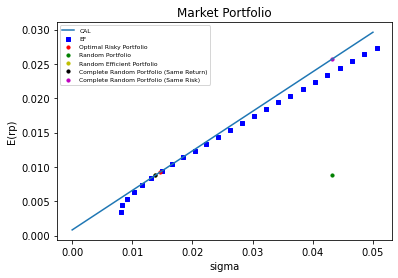

In [15]:
# Plotting
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(EF[1], EF[0], s=10, c='b', marker="s", label='EF')
ax1.scatter(ORPort[1], ORPort[0], s=10, c='r', marker="o", label='Optimal Risky Portfolio')
ax1.scatter(randPort[1], randPort[0], s=10, c='g', marker="o", label='Random Portfolio')
ax1.scatter(randPortEff[1], randPortEff[0], s=10, c='y', marker="o", label='Random Efficient Portfolio')
ax1.scatter(randPortComplete_ESame[1], randPortComplete_ESame[0], s=10, c='k', marker="o", label='Complete Random Portfolio (Same Return)')
ax1.scatter(randPortComplete_RiskSame[1], randPortComplete_RiskSame[0], s=10, c='m', marker="o", label='Complete Random Portfolio (Same Risk)')
plt.plot(calRisks, calErps, label='CAL')
plt.legend(loc='upper left', prop={'size': 6});
plt.title('Market Portfolio')
plt.xlabel('sigma')
plt.ylabel('E(rp)')
plt.show()

## Summary Results